# Named Entity Extraction (from document links)

### Background
The original request I got was to try to extract activity descriptions out of linked documents.  However, since documents formatting/organization is extremely inconsistent (so business rules aren't helpful) and we don't have a handy set of training data that we can use to build models for "what descriptions usually look like", I quickly abandoned that approach in favor of trying to pull out useful keywords (via named entity recognition) in order to populate missing data around project locations and organizations.

### Simple example (to create slide fodder for demo day)

In [1]:
import nltk

In [2]:
#Quick test example (to make pretty visuals for slides)
test='The Open Ag Initiative event was held in East London'

# Tokenize each line
tokens = nltk.word_tokenize(test)
# Apply POS Tagger on tokens
tagged = nltk.pos_tag(tokens)
# NE chunking on tags
entities = nltk.chunk.ne_chunk(tagged)


In [3]:
tokens

['The',
 'Open',
 'Ag',
 'Initiative',
 'event',
 'was',
 'held',
 'in',
 'East',
 'London']

In [28]:
tagged

[('The', 'DT'),
 ('Open', 'NNP'),
 ('Ag', 'NNP'),
 ('Initiative', 'NNP'),
 ('event', 'NN'),
 ('was', 'VBD'),
 ('held', 'VBN'),
 ('in', 'IN'),
 ('East', 'NNP'),
 ('London', 'NNP')]

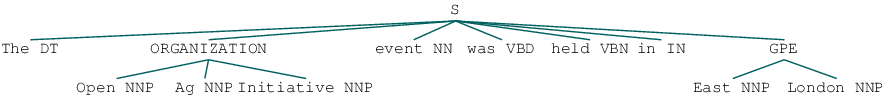

In [29]:
entities

### Actual example
Here I copied (and slightly modified to ensure the algorithm had something to find) a paragraph from a random A02 document (DFID business cases). Links to all of these [are available in Andy's gist](https://gist.github.com/andylolz/77f418301b39532922939c92ad9433c4)

In [25]:
line='''

1.	The International Climate Fund's 50% Implementation Plan identified Disaster Risk Reduction as a priority for investment. Investment in climate resilience also has co-benefits for ICF objectives on low-carbon development and greenhouse gas mitigation by avoiding the environmental degradation and unsustainable resource use often associated with disasters. It will also include activities that will have co-benefits for biodiversity conservation and the protection of carbon sinks such as mangrove restoration to protect coastal zones and drought tolerant crops.

2.	BRACED, based in Ipswich, Massachusetts, will help deliver  DFID’s commitments under the HERR and the Sahel Resilience Approach process led by Africa Regional Department. BRACED will address the priorities by ensuring resources are available to civil society organisations in the Sahel to build resilience.

3.	BRACED is linked to the programme Building resilience in the Sahel through adaptive social protection. This programme is expected to provide up to £50 million over four years to support national systems for implementing adaptive social protection in the Sahel. It will provide direct support to the poorest and most vulnerable, helping them reduce their vulnerability and build their long term resilience to climate extremes, which is vital to breaking the cycle of recurrent humanitarian crises, conflict and poverty in the region.

4.	The DFID Secretary of State co-chairs a ‘Political Champions for Disaster Resilience’ group with Helen Clark (UNDP). This group of developing country and international development ministers, and development agency heads has been convened to provide a greater focus and investment in disaster resilience. BRACED will help deliver on the UK’s commitments, as part of this group, to scale up investment in disaster resilience, and particularly in the Sahel and Horn of Africa. The programme also offers an opportunity for increasing donor and multilateral coherence by working with this group.

'''

def get_all_entities(line):
    """Same deal as above, as a function"""
    line = line.decode("utf8") #IATI documents need unicode-friendly handling
    tokens = nltk.word_tokenize(line)
    tagged = nltk.pos_tag(tokens)
    entities = nltk.chunk.ne_chunk(tagged)
    return entities


def extract_entity_names(t,entity_type):
    """
    Recursive extraction of specific entities from a tree
    Based on https://gist.github.com/onyxfish/322906
    """
    entity_names = []

    if hasattr(t, 'label') and t.label:
        if t.label() == entity_type:
            entity_names.append(' '.join([child[0] for child in t]))
        else:
            for child in t:
                entity_names.extend(extract_entity_names(child,entity_type))

    return list(set(entity_names))

#Try it out!
tree= get_all_entities(line)
result={'location':extract_entity_names(tree,'LOCATION'),
        'organization':extract_entity_names(tree,'ORGANIZATION'),
        'gpe':extract_entity_names(tree,'GPE')
        }
pp(result)

{'gpe': [u'Ipswich', u'Africa', u'Massachusetts', u'Sahel'],
 'location': [],
 'organization': [u'International Climate Fund',
                  u'DFID',
                  u'Sahel',
                  u'BRACED',
                  u'Sahel Resilience Approach',
                  u'ICF',
                  u'Horn',
                  u'UNDP',
                  u'HERR']}


It looks like the canned ne_chunk algorithm does pretty well with geopolitical entities (GPEs) and organizations, but doesn't catch locations all that well.  

### Trying again on extracted text
If this is going to work at any kind of scale, we'll need to ensure that we can do it effectively based on text parsed from the wide variety of file formats that typically get attached as document-links

In [28]:
#load URLS from a sample of Andy's gist (see above for link)
urls=[]
filenames=[]

#I just copied a handful of links into their own CSV for this
with open('document_links.csv','r') as f:
    for i in f.readlines():
        url=i.split(',')[0:2]
        urls.append(url)

In [32]:
#Download docs from list (no need to rerun this, since they're already in the repo)
import requests as r
for i in urls:
    short_name=i[39:] #Pull doc names out of URLs (quick hack since we're only using DFID docs)
    iati_filename = 'test_documents/' + short_name 
    resp=r.get(i)
    with open(iati_filename,'w') as f:
        f.write(resp.content)

In [21]:
#Extract the text
#See more about the textract module at https://github.com/deanmalmgren/textract - THIS IS MAGIC!

import textract
import os
from pprint import pprint as pp

In [106]:
#Parse all sample docs and print results for inspection
for i in os.listdir('test_documents'):
    try:
        text = textract.process('test_documents/'+i)
    except ValueError:
        print 'UNABLE TO PARSE: '+i
        print ''
        continue
    tree=get_all_entities(text)
    result={'location':extract_entity_names(tree,'LOCATION'),
            'organization':extract_entity_names(tree,'ORGANIZATION'),
            'gpe':extract_entity_names(tree,'GPE')
            }
    pp(i)
    pp(result)
    print ''
    

'2909088.xls'
{'gpe': [u'Burma',
         u'Sample',
         u'Target',
         u'Baleline',
         u'ICDP',
         u'Danida',
         u'New York',
         u'Jan',
         u'Total',
         u'D'],
 'location': [],
 'organization': [u'DFID',
                  u'UNDP',
                  u'LIFT',
                  u'HDI',
                  u'Village Development Committees',
                  u'IMPACT',
                  u'SRGs',
                  u'HIV',
                  u'UNDP Core',
                  u'MDG',
                  u'ICDP',
                  u'FTEs',
                  u'UN',
                  u'Anecdotal',
                  u'Estimate',
                  u'CBOs',
                  u'IAM',
                  u'INPUTS',
                  u'INGOs',
                  u'SRG',
                  u'Country',
                  u'CDRT',
                  u'IHLCA',
                  u'Savings',
                  u'Social',
                  u'IHLC',
                  u'UNDP Pr

XLRDError: Unsupported format, or corrupt file: Expected BOF record; found '\x15Microso'

Although the results are noisy, this seems to work pretty well for real-world document links.  Locations are useless, but we're getting reasonable results for GPEs and organizations that, with some cleaning, could be really helpful.  Not too bad for really quick hacking!

### Testing different filetypes
Document links come in all shapes and sizes, so we'll want to spot test some examples of more high-maintenance filetypes to make sure they play nice with our approach here

In [99]:
#What kind of text can we get out of those weird Excel logframe docs?
print text #It happens that the last of our test docs was excel, so we can quickly check it out


LIFT Logical Framework (2015-2018)
Last updated: 8 January 2016
LEVEL Indicator Milestone 
2015 Milestone 
2016 Milestone 
2017 Target 
2018
PURPOSE: To improve the incomes and nutrition status of poor people in Myanmar by promoting resilient livelihoods and food security
PO 1: 
Increased incomes of rural households PO 1.1: Number of LIFT households with increased income (by sex of HH head) 138000.0 217234.2 305076.4 364119.0
PO 1.2: % of households in LIFT villages below the poverty line (by sex of HH head) 30.0 28.32 21.0 15.0
PO 2:
Increased resilience of rural households and communities to shocks, stresses and adverse trends PO 2.1: Number of LIFT households with increased asset ownership score (by sex of HH head) 50217.0 79125.4 110065.0 125716.0
PO 2.2: Number of LIFT households with increased income diversity score (by sex of HH head) 14871.6 33017.4 44438.0
PO 2.3: Number of people whose resilience has been improved and ability to cope has increased (by sex) 788294.0 1135424.2

In [121]:
# Test a PDF to make sure it works
text = textract.process('test.pdf',method='pdfminer') #Make sure you specify the method for PDFs
tree=get_all_entities(text)
result={'location':extract_entity_names(tree,'LOCATION'),
        'organization':extract_entity_names(tree,'ORGANIZATION'),
        'gpe':extract_entity_names(tree,'GPE')
        }
pp(result)
    

{'gpe': [u'Indicateurs',
         u'Cr\xe9ation',
         u'Fonds',
         u'Improved',
         u'Port\xe9e',
         u'Calendrier',
         u'Frais',
         u'Assistance',
         u'\xc9laboration',
         u'Immunization',
         u'Zimbabwe',
         u'Bureau',
         u'Afrique',
         u'Agence',
         u'Total',
         u'Banque',
         u'UNAIDS',
         u'Acquisition'],
 'location': [],
 'organization': [u'Unit\xe9',
                  u'satisfaisantSatisfaisantTOTAL',
                  u'TIZ',
                  u'Autres Conditions Dans',
                  u'HARVEST Pr\xeat',
                  u'Social',
                  u'CCP',
                  u'Composantes Activit\xe9s',
                  u'WLA',
                  u'RECOMMANDATION La',
                  u'Composantes',
                  u'Combat',
                  u'RESSOURCES Don',
                  u'PIB',
                  u'PPP',
                  u'Alignement',
                  u'CONSEIL',
     

Sure enough, our text extraction process manages to make a decent looking BOW out of excel's gobbledygook.  It does ok with PDFs too, but the resulting NE extraction isn't great because this particular test pdf I grabbed happens to be in French (and of course, NLTK's OOTB models are only based on English).  As a POC, we'll take it.

### Applying our process on results
Up to this point, we'd been using business case documents as inputs.  These are produced early on in the process of proposing an activity, so it's likely that they might not have the level of detail required to make this approach practically useful.  Given that, we tried again using a result document.  These are written only upon completion of a project, when many more details will have been determined and can be thoroughly documented. If this works, it could potentially enable "retroactive data cleansing" processes in which missing elements are imputed if they can be extracted from linked documents.  Subnational location data could also be used to support better mapping (see the work being done by [Development Gateway](http://www.developmentgateway.org/))

In [26]:
#Do we get a better result with a results document?
text = textract.process('test_documents/A07.odt') #Test document provided by James Coe
tree=get_all_entities(text)
result={#'location':extract_entity_names(tree,'LOCATION'), #Let's not even bother with locations anymore
        'organization':extract_entity_names(tree,'ORGANIZATION'),
        'gpe':extract_entity_names(tree,'GPE')
        }
pp(result)
    

{'gpe': [u'Review',
         u'Uwezo',
         u'Asia',
         u'Policy',
         u'Type',
         u'Europe',
         u'Tanzanian',
         u'Christian',
         u'Finance',
         u'New York City',
         u'Sikika',
         u'Kilimanjaro',
         u'Dar',
         u'Dodoma',
         u'Change',
         u'Organizations',
         u'Twaweza',
         u'Tanzania',
         u'Mwanza',
         u'Daladala',
         u'Iringa',
         u'Supported',
         u'New York',
         u'Ruvuma',
         u'Kenya',
         u'Education',
         u'Open',
         u'Twitter'],
 'organization': [u'Environment Risk Twaweza',
                  u'Use',
                  u'TEC',
                  u'Masoko',
                  u'Constitution',
                  u'USA',
                  u'PCCB',
                  u'CCT',
                  u'NGO',
                  u'SMS',
                  u'School',
                  u'ToC',
                  u'CC',
                  u'PAC',
          

Here, we see much more specific details around both organizations and GPEs (especially sub-national location data, which show up as Tanzanian towns in this particular example).  This is a promising start, though much more testing will need to be done to determine the scalability of this approach.

In [ ]:
# Alternate NER Tagging model - requires Java though (so I didn't use this one)
from nltk.tag import StanfordNERTagger
st = StanfordNERTagger('english.all.3class.distsim.crf.ser.gz') 
st.tag('Rami Eid is studying at Stony Brook University in NY'.split()) 